# Data Preprocessing Introduction

本節課將示範一些常用的基本資料處理操作與檢查，並且分享TUIC內部使用的處理function，旨在讓大家能執行基本的資料處理。環境將使用Colab線上執行python，並主要透過pandas、geopandas兩個packages操作。上半堂聚焦於一般型態資料處理，下半堂聚焦於空間資料處理。  

*(本競賽不限制資料處理方式，python是現今流行的資料科學程式語言，但並非唯一的工具，當資料很小又不需要自動化時，Excel也是不錯的工具。)*

資料前處理的本質是為了將資料處理成下個階段可以使用的形式，要做什麼處理完全取決於原始資料與目標間的差別。因此在正式開始資料處理前，建議可參考以下步驟:

1. Understanding Input and Output Data
2. Designing Processing Plans
3. Coding

Coding內容完全視資料與目標而定，並無固定方式，以下提供我們常用的結構，請隨你的需求調整:


In [ ]:
# 0.Set Config
# 1.Collection
# 2.Inspection
# 3.Rename
# 4.Define data type
# 5.Fill missing value
# 6....... other process ......
# 7.Select
# 8.Save

# 實作 - 原始資料初步清理轉換

## install necessary packages

In [ ]:
!pip install geocoder==1.38.1
!pip install geopandas==0.13.2
!pip install shapely==2.0.2
!pip install keplergl==0.3.2

import and pre-load funtion

In [2]:
# 上傳./src/func.py，並執行以下程序

import geopandas as gpd
import geocoder
import json
import pandas as pd
from shapely.geometry import LineString, Point, Polygon

from google.colab import files
uploaded = files.upload()
%run func.py

本節課將實作2個資料流，並提供1個資料流作為課堂練習。  
實作2個資料流如下，其中B資料流在上半堂不會完成，其中涉及的空間處理將在本節的下半堂繼續。  
(*格式: [input data]+[input data] -> [output data]*)
* A.臺北市身心障礙者福利服務 -> 無障礙需求歷年趨勢
* B.身障機構收容暨空位狀態+身障就業資源地圖+村里界 -> 身障友善機構

## **A.臺北市身心障礙者福利服務 -> 無障礙需求歷年趨勢**

### Designing Processing Plan

(實際步驟是先了解`Input data`與`Output data`才制定出`處理計畫`，但為了閱讀方便，將計畫放在最前面)
1. 修改欄位名
2. 民國年修改成西元年
3. 定義data type
4. 選擇指定欄位

In [ ]:
# Ouput data- 無障礙需求歷年趨勢
RAW_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/2-Initial-Data-Cleaning-Visualization/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv?token=GHSAT0AAAAAACHYWWNICD23CYPEE25UQQSSZJXOERA'
FILE_NAME = 'accessibility_need_over_the_years.csv'
!wget $RAW_DATA_URL -O $FILE_NAME
accessibility_need = pd.read_csv(FILE_NAME)

--2023-10-24 07:23:33--  https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/2-Initial-Data-Cleaning-Visualization/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv?token=GHSAT0AAAAAACHYWWNICD23CYPEE25UQQSSZJXOERA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1511 (1.5K) [text/plain]
Saving to: ‘accessibility_need_over_the_years.csv’

accessibility_need_ 100%[===================>]   1.48K  --.-KB/s    in 0s      

2023-10-24 07:23:34 (22.5 MB/s) - ‘accessibility_need_over_the_years.csv’ saved [1511/1511]



In [ ]:
accessibility_need.head()

,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995年,"37,007,518","123,629,720","67,958,515"
1,1996年,"91,367,929","265,961,218","59,513,472"
2,1997年,"68,788,296","168,770,548","63,790,107"
3,1998年,"174,731,400","160,737,510","82,575,662"
4,1999年,"158,774,563","140,545,519","91,165,386"


In [ ]:
# Input data- 臺北市身心障礙者福利服務
disability_welfare = get_datataipei_api('a09d5ff1-6b83-4bce-abbb-480b126db611')
disability_welfare.shape

(28, 38)

In [ ]:
disability_welfare.head()

,_id,_importdate,年別,住宿及照顧福利機構家數[家],住宿及照顧福利機構核定服務人數[人],住宿及照顧福利機構實際服務人數[人],福利服務中心家數[家],福利服務中心服務人次[人次],日間及住宿式照顧補助人次[人次],日間及住宿式照顧補助金額[元],...,職場手語翻譯服務人次[人次],職場手語翻譯服務男性人次[人次],職場手語翻譯服務女性人次[人次],職場聽打服務/申請案件數[件],職場聽打服務時間[小時],職場聽打服務人次[人次],職場聽打男性服務人次[人次],職場聽打女性服務人次[人次],醫療及醫療輔具補助人次[人次],醫療及醫療輔具補助金額[元]
0,1,"{'date': '2023-04-13 09:59:46.642404', 'timezo...",84年,20,-,1142,5,-,862,37007518,...,-,-,-,-,-,-,-,-,-,-
1,2,"{'date': '2023-04-13 09:59:46.655343', 'timezo...",85年,24,-,1417,-,-,1142,91367929,...,-,-,-,-,-,-,-,-,-,-
2,3,"{'date': '2023-04-13 09:59:46.656965', 'timezo...",86年,23,-,1709,7,7694,4464,68788296,...,-,-,-,-,-,-,-,-,-,-
3,4,"{'date': '2023-04-13 09:59:46.658155', 'timezo...",87年,28,-,1351,6,6758,9876,174731400,...,-,-,-,-,-,-,-,-,-,-
4,5,"{'date': '2023-04-13 09:59:46.659465', 'timezo...",88年,28,775,1468,6,32763,4588,158774563,...,-,-,-,-,-,-,-,-,-,-


In [ ]:
disability_welfare.dtypes

_id                    int64
_importdate           object
年別                    object
住宿及照顧福利機構家數[家]        object
住宿及照顧福利機構核定服務人數[人]    object
住宿及照顧福利機構實際服務人數[人]    object
福利服務中心家數[家]           object
福利服務中心服務人次[人次]        object
日間及住宿式照顧補助人次[人次]      object
日間及住宿式照顧補助金額[元]       object
生活補助人次[人次]            object
生活補助金額[元]             object
輔具補助人次[人次]            object
輔具補助金額[元]             object
職業訓練結訓人數[人]           object
職業訓練男性結訓人數[人]         object
職業訓練女性結訓人數[人]         object
職業輔導評量服務人次[人次]        object
職業輔導評量男性人次[人次]        object
職業輔導評量女性人次[人次]        object
求職登記人數[人]             object
求職登記人數/男性[人]          object
求職登記人數/女性[人]          object
輔導就業人數[人]             object
輔導就業人數/男性[人]          object
輔導就業人數/女性[人]          object
職場手語翻譯申請案件數[件]        object
職場手語翻譯時間[小時]          object
職場手語翻譯服務人次[人次]        object
職場手語翻譯服務男性人次[人次]      object
職場手語翻譯服務女性人次[人次]      object
職場聽打服務/申請案件數[件]       object
職場聽打服務時間[小時]          object
職場聽打服務人次[人次]          object
職場聽打男性服務人次[人次]

1. 修改欄位名
2. 民國年修改成西元年
3. 定義data type
4. 選擇指定欄位

### ETL code

預設儲存資料於`/content`路徑下

In [ ]:
import pandas as pd

# Designing Processing Plan
# 1. 修改欄位名，[]變成()
# 2. 民國年修改成西元年
# 3. 定義data type，具量詞欄位應為float

# 0.Set Config
RID = 'a09d5ff1-6b83-4bce-abbb-480b126db611'
GITHUB_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/2-Initial-Data-Cleaning-Visualization/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv?token=GHSAT0AAAAAACHYWWNICD23CYPEE25UQQSSZJXOERA'
GITHUB_DOWNLOAD_FILE_NAME = 'accessibility_need_over_the_years.csv'
OUTPUT_FILENAME = 'disability_welfare_over_the_years.csv'

# 1.Collection
# input 臺北市身心障礙者福利服務
raw_disability_welfare = get_datataipei_api(RID)
# output sample 無障礙需求歷年趨勢
!wget $GITHUB_DATA_URL -O $GITHUB_DOWNLOAD_FILE_NAME
raw_accessibility_need = pd.read_csv(GITHUB_DOWNLOAD_FILE_NAME)

--2023-10-24 07:26:35--  https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/2-Initial-Data-Cleaning-Visualization/Datasets/Processed/%E7%84%A1%E9%9A%9C%E7%A4%99%E9%9C%80%E6%B1%82%E6%AD%B7%E5%B9%B4%E8%B6%A8%E5%8B%A2.csv?token=GHSAT0AAAAAACHYWWNICD23CYPEE25UQQSSZJXOERA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1511 (1.5K) [text/plain]
Saving to: ‘accessibility_need_over_the_years.csv’

accessibility_need_ 100%[===================>]   1.48K  --.-KB/s    in 0s      

2023-10-24 07:26:36 (20.1 MB/s) - ‘accessibility_need_over_the_years.csv’ saved [1511/1511]



In [ ]:
disability_welfare = raw_disability_welfare.copy()
accessibility_need = raw_accessibility_need.copy()

In [ ]:
# 2.Inspection
print('臺北市身心障礙者福利服務:')
print(disability_welfare.columns)

print('無障礙需求歷年趨勢:')
print(accessibility_need.columns)

臺北市身心障礙者福利服務:
Index(['_id', '_importdate', '年別', '住宿及照顧福利機構家數[家]', '住宿及照顧福利機構核定服務人數[人]',
       '住宿及照顧福利機構實際服務人數[人]', '福利服務中心家數[家]', '福利服務中心服務人次[人次]',
       '日間及住宿式照顧補助人次[人次]', '日間及住宿式照顧補助金額[元]', '生活補助人次[人次]', '生活補助金額[元]',
       '輔具補助人次[人次]', '輔具補助金額[元]', '職業訓練結訓人數[人]', '職業訓練男性結訓人數[人]',
       '職業訓練女性結訓人數[人]', '職業輔導評量服務人次[人次]', '職業輔導評量男性人次[人次]', '職業輔導評量女性人次[人次]',
       '求職登記人數[人]', '求職登記人數/男性[人]', '求職登記人數/女性[人]', '輔導就業人數[人]',
       '輔導就業人數/男性[人]', '輔導就業人數/女性[人]', '職場手語翻譯申請案件數[件]', '職場手語翻譯時間[小時]',
       '職場手語翻譯服務人次[人次]', '職場手語翻譯服務男性人次[人次]', '職場手語翻譯服務女性人次[人次]',
       '職場聽打服務/申請案件數[件]', '職場聽打服務時間[小時]', '職場聽打服務人次[人次]', '職場聽打男性服務人次[人次]',
       '職場聽打女性服務人次[人次]', '醫療及醫療輔具補助人次[人次]', '醫療及醫療輔具補助金額[元]'],
      dtype='object')
無障礙需求歷年趨勢:
Index(['年份', '日間及住宿式照顧補助金額(元)', '生活補助金額(元)', '輔具補助金額(元)'], dtype='object')


In [ ]:
disability_welfare.isna().sum(axis=0)

_id                   0
_importdate           0
年別                    0
住宿及照顧福利機構家數[家]        0
住宿及照顧福利機構核定服務人數[人]    0
住宿及照顧福利機構實際服務人數[人]    0
福利服務中心家數[家]           0
福利服務中心服務人次[人次]        0
日間及住宿式照顧補助人次[人次]      0
日間及住宿式照顧補助金額[元]       0
生活補助人次[人次]            0
生活補助金額[元]             0
輔具補助人次[人次]            0
輔具補助金額[元]             0
職業訓練結訓人數[人]           0
職業訓練男性結訓人數[人]         0
職業訓練女性結訓人數[人]         0
職業輔導評量服務人次[人次]        0
職業輔導評量男性人次[人次]        0
職業輔導評量女性人次[人次]        0
求職登記人數[人]             0
求職登記人數/男性[人]          0
求職登記人數/女性[人]          0
輔導就業人數[人]             0
輔導就業人數/男性[人]          0
輔導就業人數/女性[人]          0
職場手語翻譯申請案件數[件]        0
職場手語翻譯時間[小時]          0
職場手語翻譯服務人次[人次]        0
職場手語翻譯服務男性人次[人次]      0
職場手語翻譯服務女性人次[人次]      0
職場聽打服務/申請案件數[件]       0
職場聽打服務時間[小時]          0
職場聽打服務人次[人次]          0
職場聽打男性服務人次[人次]        0
職場聽打女性服務人次[人次]        0
醫療及醫療輔具補助人次[人次]       0
醫療及醫療輔具補助金額[元]        0
dtype: int64

In [ ]:
disability_welfare['住宿及照顧福利機構核定服務人數[人]'].value_counts(dropna=False)

-       4
2436    2
2396    1
2291    1
2281    1
2305    1
2339    1
2371    1
2424    1
2480    1
2451    1
2466    1
2426    1
775     1
2310    1
2254    1
2242    1
2161    1
2142    1
2103    1
2068    1
1841    1
1723    1
2253    1
Name: 住宿及照顧福利機構核定服務人數[人], dtype: int64

In [ ]:
# 3.Rename
# 修改欄位名，[]變成()
# disability_welfare.rename(columns={'old_column_name': 'new_column_name'}, inplace=True)
# disability_welfare.columns = ['column_name1', 'column_name2']

# loop
col_map = {}
for col in disability_welfare.columns:
    new_col = col.replace('[', '(').replace(']', ')')
    col_map[col] = new_col
disability_welfare.rename(columns=col_map, inplace=True)
disability_welfare.rename(columns={'年別': '年份'}, inplace=True)
disability_welfare.columns

Index(['_id', '_importdate', '年份', '住宿及照顧福利機構家數(家)', '住宿及照顧福利機構核定服務人數(人)',
       '住宿及照顧福利機構實際服務人數(人)', '福利服務中心家數(家)', '福利服務中心服務人次(人次)',
       '日間及住宿式照顧補助人次(人次)', '日間及住宿式照顧補助金額(元)', '生活補助人次(人次)', '生活補助金額(元)',
       '輔具補助人次(人次)', '輔具補助金額(元)', '職業訓練結訓人數(人)', '職業訓練男性結訓人數(人)',
       '職業訓練女性結訓人數(人)', '職業輔導評量服務人次(人次)', '職業輔導評量男性人次(人次)', '職業輔導評量女性人次(人次)',
       '求職登記人數(人)', '求職登記人數/男性(人)', '求職登記人數/女性(人)', '輔導就業人數(人)',
       '輔導就業人數/男性(人)', '輔導就業人數/女性(人)', '職場手語翻譯申請案件數(件)', '職場手語翻譯時間(小時)',
       '職場手語翻譯服務人次(人次)', '職場手語翻譯服務男性人次(人次)', '職場手語翻譯服務女性人次(人次)',
       '職場聽打服務/申請案件數(件)', '職場聽打服務時間(小時)', '職場聽打服務人次(人次)', '職場聽打男性服務人次(人次)',
       '職場聽打女性服務人次(人次)', '醫療及醫療輔具補助人次(人次)', '醫療及醫療輔具補助金額(元)'],
      dtype='object')

In [ ]:
# 4.Define data type
# 定義data type，具量詞欄位應為float
# (int無法容許np.nan)
disability_welfare['年份'] = disability_welfare['年份'].astype(str)
df_row_len, df_col_len = disability_welfare.shape
for col_index in range(3, df_col_len):
    col_name = disability_welfare.columns[col_index]
    fine_col = disability_welfare[col_name].copy()
    is_dash = (fine_col=='-')
    fine_col.loc[is_dash] = None
    fine_col = fine_col.astype(float)
    disability_welfare[col_name] = fine_col
disability_welfare.dtypes

_id                     int64
_importdate            object
年份                     object
住宿及照顧福利機構家數(家)        float64
住宿及照顧福利機構核定服務人數(人)    float64
住宿及照顧福利機構實際服務人數(人)    float64
福利服務中心家數(家)           float64
福利服務中心服務人次(人次)        float64
日間及住宿式照顧補助人次(人次)      float64
日間及住宿式照顧補助金額(元)       float64
生活補助人次(人次)            float64
生活補助金額(元)             float64
輔具補助人次(人次)            float64
輔具補助金額(元)             float64
職業訓練結訓人數(人)           float64
職業訓練男性結訓人數(人)         float64
職業訓練女性結訓人數(人)         float64
職業輔導評量服務人次(人次)        float64
職業輔導評量男性人次(人次)        float64
職業輔導評量女性人次(人次)        float64
求職登記人數(人)             float64
求職登記人數/男性(人)          float64
求職登記人數/女性(人)          float64
輔導就業人數(人)             float64
輔導就業人數/男性(人)          float64
輔導就業人數/女性(人)          float64
職場手語翻譯申請案件數(件)        float64
職場手語翻譯時間(小時)          float64
職場手語翻譯服務人次(人次)        float64
職場手語翻譯服務男性人次(人次)      float64
職場手語翻譯服務女性人次(人次)      float64
職場聽打服務/申請案件數(件)       float64
職場聽打服務時間(小時)          float64
職場聽打服務人次(人

In [ ]:
# 5.Fill missing value
disability_welfare.isna().sum(axis=0)

_id                    0
_importdate            0
年份                     0
住宿及照顧福利機構家數(家)         0
住宿及照顧福利機構核定服務人數(人)     4
住宿及照顧福利機構實際服務人數(人)     0
福利服務中心家數(家)            1
福利服務中心服務人次(人次)         4
日間及住宿式照顧補助人次(人次)       0
日間及住宿式照顧補助金額(元)        0
生活補助人次(人次)             0
生活補助金額(元)              0
輔具補助人次(人次)             0
輔具補助金額(元)              0
職業訓練結訓人數(人)           20
職業訓練男性結訓人數(人)         20
職業訓練女性結訓人數(人)         20
職業輔導評量服務人次(人次)        20
職業輔導評量男性人次(人次)        20
職業輔導評量女性人次(人次)        20
求職登記人數(人)             20
求職登記人數/男性(人)          20
求職登記人數/女性(人)          20
輔導就業人數(人)             20
輔導就業人數/男性(人)          20
輔導就業人數/女性(人)          20
職場手語翻譯申請案件數(件)        20
職場手語翻譯時間(小時)          20
職場手語翻譯服務人次(人次)        20
職場手語翻譯服務男性人次(人次)      21
職場手語翻譯服務女性人次(人次)      21
職場聽打服務/申請案件數(件)       21
職場聽打服務時間(小時)          21
職場聽打服務人次(人次)          21
職場聽打男性服務人次(人次)        21
職場聽打女性服務人次(人次)        21
醫療及醫療輔具補助人次(人次)       20
醫療及醫療輔具補助金額(元)        20
dtype: int64

In [ ]:
disability_welfare.iloc[:, 3:].describe()

,住宿及照顧福利機構家數(家),住宿及照顧福利機構核定服務人數(人),住宿及照顧福利機構實際服務人數(人),福利服務中心家數(家),福利服務中心服務人次(人次),日間及住宿式照顧補助人次(人次),日間及住宿式照顧補助金額(元),生活補助人次(人次),生活補助金額(元),輔具補助人次(人次),...,職場手語翻譯服務人次(人次),職場手語翻譯服務男性人次(人次),職場手語翻譯服務女性人次(人次),職場聽打服務/申請案件數(件),職場聽打服務時間(小時),職場聽打服務人次(人次),職場聽打男性服務人次(人次),職場聽打女性服務人次(人次),醫療及醫療輔具補助人次(人次),醫療及醫療輔具補助金額(元)
count,28.000000,24.000000,28.000000,27.000000,24.000000,28.000000,2.800000e+01,28.000000,2.800000e+01,28.000000,...,8.000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000e+00
mean,38.107143,2207.250000,1933.142857,4.444444,36084.916667,15199.428571,7.744132e+08,104554.857143,6.177501e+08,9659.107143,...,825.500,495.142857,317.285714,110.571429,772.000000,120.571429,43.000000,77.571429,1963.875000,1.350599e+07
std,7.771454,359.633056,338.265151,1.867399,27203.769713,7001.900379,4.324777e+08,56763.831775,3.655220e+08,3032.658391,...,149.172,97.468676,65.751335,29.523195,403.130355,35.622358,11.165423,29.136787,887.008043,4.075645e+06
min,20.000000,775.000000,1142.000000,2.000000,6758.000000,862.000000,3.700752e+07,24820.000000,1.236297e+08,3064.000000,...,530.000,322.000000,208.000000,84.000000,289.000000,90.000000,26.000000,58.000000,1004.000000,9.738934e+06
25%,34.750000,2156.250000,1675.500000,2.500000,15871.000000,11977.750000,5.583973e+08,50507.500000,2.646667e+08,7298.750000,...,818.500,464.500000,281.000000,89.000000,506.250000,102.000000,36.500000,63.500000,1340.750000,1.045658e+07
50%,41.500000,2298.000000,2091.500000,4.000000,26164.000000,14818.000000,7.082240e+08,94519.000000,5.174302e+08,9963.500000,...,877.500,518.000000,356.000000,106.000000,694.000000,105.000000,44.000000,65.000000,1786.500000,1.161876e+07
75%,43.000000,2424.500000,2155.750000,6.000000,49972.250000,21993.500000,1.212046e+09,163703.500000,9.836397e+08,12144.000000,...,921.500,540.000000,358.000000,118.500000,1017.250000,124.500000,50.000000,76.000000,2167.750000,1.656737e+07
max,47.000000,2480.000000,2298.000000,7.000000,98116.000000,24212.000000,1.355874e+09,177569.000000,1.138271e+09,13777.000000,...,937.000,617.000000,379.000000,169.000000,1374.000000,196.000000,58.000000,141.000000,3556.000000,2.060810e+07


In [ ]:
# 6. ......other process......
# 民國年修改成西元年
chinese_year = disability_welfare['年份'].str.replace('年', '')
bc_year = chinese_year.astype(int) + 1911
bc_year = bc_year.astype(str) + '年'
disability_welfare['年份'] = bc_year
disability_welfare['年份']

0     1995年
1     1996年
2     1997年
3     1998年
4     1999年
5     2000年
6     2001年
7     2002年
8     2003年
9     2004年
10    2005年
11    2006年
12    2007年
13    2008年
14    2009年
15    2010年
16    2011年
17    2012年
18    2013年
19    2014年
20    2015年
21    2016年
22    2017年
23    2018年
24    2019年
25    2020年
26    2021年
27    2022年
Name: 年份, dtype: object

In [ ]:
# 7.Select
# 年份                 object
# 日間及住宿式照顧補助金額(元)    object
# 生活補助金額(元)          object
# 輔具補助金額(元)          object
select_col = ['年份', '日間及住宿式照顧補助金額(元)', '生活補助金額(元)', '輔具補助金額(元)']
disability_welfare = disability_welfare[select_col]
disability_welfare.head()

,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995年,37007518.0,123629720.0,67958515.0
1,1996年,91367929.0,265961218.0,59513472.0
2,1997年,68788296.0,168770548.0,63790107.0
3,1998年,174731400.0,160737510.0,82575662.0
4,1999年,158774563.0,140545519.0,91165386.0


In [ ]:
accessibility_need.head()

,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995年,"37,007,518","123,629,720","67,958,515"
1,1996年,"91,367,929","265,961,218","59,513,472"
2,1997年,"68,788,296","168,770,548","63,790,107"
3,1998年,"174,731,400","160,737,510","82,575,662"
4,1999年,"158,774,563","140,545,519","91,165,386"


In [ ]:
# 8.Save
disability_welfare.to_csv(OUTPUT_FILENAME, index=False, encoding='UTF-8')

可下載處理完的資料`./content/disability_welfare_over_the_years.csv`

## **B.臺北市身障設施+臺北市身障社區長照機構+村里界 -> 身障友善機構**

### Designing Processing Plan

將`身障機構收容暨空位狀態`與`臺北市身障社區長照機構`合併成一個資料集，並產生適合的空間資訊。
1. 一致的columns name
2. 正確的column type
3. `臺北市身障社區長照機構`須加上"屬性"
4. 利用地址為`臺北市身障社區長照機構`加上行政區
5. (下半)利用Geocoder取得座標
6. (下半)產生TWD97座標值
7. (下半)利用村里界取得行政區
8. (下半)合併`身障機構收容暨空位狀態`與`臺北市身障社區長照機構`

In [6]:
# Output data- 身障友善機構
URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E8%BA%AB%E9%9A%9C%E5%8F%8B%E5%96%84%E6%A9%9F%E6%A7%8B.csv?token=GHSAT0AAAAAACHYWWNJ7QSB7BYLARDE6UTCZJYZ54A'
FILE_NAME = 'disable_friendly_institutions.csv'
!wget $URL -O $FILE_NAME

# 上傳data
friendly_institution = pd.read_csv(FILE_NAME)

--2023-10-25 08:18:13--  https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E8%BA%AB%E9%9A%9C%E5%8F%8B%E5%96%84%E6%A9%9F%E6%A7%8B.csv?token=GHSAT0AAAAAACHYWWNJ7QSB7BYLARDE6UTCZJYZ54A
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40669 (40K) [text/plain]
Saving to: ‘disable_friendly_institutions.csv’

disable_friendly_in 100%[===================>]  39.72K  --.-KB/s    in 0.01s   

2023-10-25 08:18:13 (2.99 MB/s) - ‘disable_friendly_institutions.csv’ saved [40669/40669]



In [ ]:
friendly_institution.head()

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lon,lat,is_accessi
0,1,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是
1,2,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是
3,4,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.00,121.549477,25.110765,否
4,5,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.00,121.541206,25.135172,否


In [7]:
# 身障設施
URL = 'https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=57d8db7f-21a9-413f-8158-1df3b3d66d75'
FILE_NAME = 'disable_institutions.zip'
!wget $URL -O $FILE_NAME
!unzip -d disable_institutions -O BIG5 $FILE_NAME

disable_institution = gpd.read_file('./disable_institutions/身障設施_202309.shp')

--2023-10-25 08:21:25--  https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=57d8db7f-21a9-413f-8158-1df3b3d66d75
Resolving data.taipei (data.taipei)... 210.69.108.244, 2001:4420:6006:157::32
Connecting to data.taipei (data.taipei)|210.69.108.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17876 (17K) [application/zip]
Saving to: ‘disable_institutions.zip’

disable_institution 100%[===================>]  17.46K  90.5KB/s    in 0.2s    

2023-10-25 08:21:26 (90.5 KB/s) - ‘disable_institutions.zip’ saved [17876/17876]

Archive:  disable_institutions.zip
 extracting: disable_institutions/身障設施_202309.cpg  
  inflating: disable_institutions/身障設施_202309.dbf  
  inflating: disable_institutions/身障設施_202309.prj  
  inflating: disable_institutions/身障設施_202309.sbn  
  inflating: disable_institutions/身障設施_202309.sbx  
  inflating: disable_institutions/身障設施_202309.shp  
  inflating: disable_institutions/身障設施_202309.shx  


In [ ]:
disable_institution.head()

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lon,lat,is_accessi,geometry
0,1,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
1,2,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是,POINT (303689.900 2778225.000)
3,4,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.00,121.549477,25.110765,否,POINT (305415.200 2778159.000)
4,5,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.00,121.541206,25.135172,否,POINT (304569.600 2780859.000)


In [3]:
# 臺北市身障社區長照機構
# https://data.taipei/dataset/detail?id=06a3d0c3-1949-4501-b16f-a0c4c036e2d5

# 直接儲存到RAM
rid = '5e6dd32d-ac91-48cd-87ab-776fcc4811b7'
raw_disability_community_longterm_care_institutions = get_datataipei_api(rid)

# 上傳再讀取
# upload file to Colab
# raw_disability_community_longterm_care_institutions = pd.read_csv(
#     '身障社區長照機構.csv', encoding='big5'
# )
dis_longterm = raw_disability_community_longterm_care_institutions.copy()
dis_longterm.head()

,_id,_importdate,機構類型,機構名稱,地址,電話
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933


### ETL Code

將`身障機構收容暨空位狀態`與`臺北市身障社區長照機構`合併成一個資料集，並產生適合的空間資訊。
1. 一致的columns name
2. 正確的column type
3. `臺北市身障社區長照機構`須加上"屬性"
4. 利用地址為`臺北市身障社區長照機構`加上行政區
5. (下半)利用Geocoder取得座標
6. (下半)產生TWD97座標值
7. (下半)利用村里界取得行政區
8. (下半)合併`身障機構收容暨空位狀態`與`臺北市身障社區長照機構`

In [59]:
# 0.Set Config
INSTITUTION_URL = 'https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=57d8db7f-21a9-413f-8158-1df3b3d66d75'
INSTITUTION_FILE_NAME = 'disable_institutions.zip'
INSTITUTION_FOLDER = 'disable_institutions'
LONGTERM_RID = '5e6dd32d-ac91-48cd-87ab-776fcc4811b7'
GITHUB_DATA_URL = 'https://raw.githubusercontent.com/tpe-doit/Taipei-Codefest-2023-Workshop/3-ETL/Datasets/Processed/%E8%BA%AB%E9%9A%9C%E5%8F%8B%E5%96%84%E6%A9%9F%E6%A7%8B.csv?token=GHSAT0AAAAAACHYWWNIZWPL36D3VIXR74BUZJY233Q'
GITHUB_DOWNLOAD_FILE_NAME = 'disable_friendly_institution.csv'
OUTPUT_FILENAME = 'disable_friendly_facility.csv'

In [60]:
# 1.Collection
# Input- 身障機構收容暨空位狀態
!wget $URL -O $FILE_NAME
!unzip -d $INSTITUTION_FOLDER -O BIG5 -o $INSTITUTION_FILE_NAME
raw_disable_institution = gpd.read_file(
    f'./{INSTITUTION_FOLDER}/身障設施_202309.shp', from_crs='EPSG:3826'
)
# Input- 臺北市身障社區長照機構
raw_disability_community_longterm_care_institutions = get_datataipei_api(LONGTERM_RID)
# output sample 身障友善機構
!wget $GITHUB_DATA_URL -O $GITHUB_DOWNLOAD_FILE_NAME
raw_friendly_institution = pd.read_csv(GITHUB_DOWNLOAD_FILE_NAME)

zsh:1: command not found: wget
UnZip 6.00 of 20 April 2009, by Info-ZIP.  Maintained by C. Spieler.  Send
bug reports using http://www.info-zip.org/zip-bug.html; see README for details.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make dir

DriverError: ./disable_institutions/身障設施_202309.shp: No such file or directory

In [130]:
# copy raw data
dis_longterm = raw_disability_community_longterm_care_institutions.copy()
dis_institution = raw_disable_institution.copy()
friendly_institution = raw_friendly_institution.copy()

In [112]:
# 2.Inspection
dis_institution.head()

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lng,lat,is_accessi,geometry
0,1,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
1,2,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是,POINT (303689.900 2778225.000)
3,4,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.00,121.549477,25.110765,否,POINT (305415.200 2778159.000)
4,5,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.00,121.541206,25.135172,否,POINT (304569.600 2780859.000)


In [ ]:
dis_longterm.head()

,_id,_importdate,機構類型,機構名稱,地址,電話
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933


In [ ]:
dis_institution['type'].value_counts()

共融式遊戲場            55
社區日間作業設施          30
住宿機構              21
日間服務機構            20
身心障礙者資源中心          9
身心障礙者社區日間活動據點      9
身障社區長照機構（日間照顧）     6
團體家庭               5
精神障礙者會所            5
福利服務中心             4
輔具服務中心             4
委託方案               4
B0102              3
Name: type, dtype: int64

In [ ]:
dis_longterm['機構類型'].value_counts()

身障社區長照機構(日間照顧)    4
Name: 機構類型, dtype: int64

In [4]:
# 3.Rename
col_map = {
    '機構類型': 'type',
    '機構名稱': 'name',
    '地址': 'addr',
    '電話': 'tel'
}
dis_longterm.rename(columns=col_map, inplace=True)

In [132]:
dis_institution.rename(columns={'lon': 'lng'}, inplace=True)

In [5]:
# 4.Define data type
# 5.Fill missing value
# 6....... other process ......
# 3. `臺北市身障社區長照機構`須加上"屬性"
dis_longterm['attr'] = '待查'
# 4. 利用地址為`臺北市身障社區長照機構`加上行政區
# 正則表達式取得指定字串，'臺北市([非數字的]{2個字}區)'
dis_longterm['town'] = dis_longterm['addr'].str.extract('臺北市([^\\d]{2}區)')

### 正則表達式:
https://docs.python.org/zh-tw/3/howto/regex.html

In [ ]:
import re

pattern = '123'  # 比對給定文字
text = "123 abc 456123"
result = re.findall(pattern, text)
print(result)

['123', '123']


In [ ]:
pattern = '^123'  # 左邊界接給定文字
result = re.findall(pattern, text)
print(result)

['123']


In [ ]:
pattern = '456(123)'  # group
result = re.findall(pattern, text)
print(result)

['123']


In [ ]:
pattern = '456\(123\)'  # group
result = re.findall(pattern, text)
print(result)

[]


In [ ]:
pattern = '456\(123\)'  # group
result = re.findall(pattern, '123 456(123)')
print(result)

['456(123)']


In [ ]:
pattern = '\\d{6}'  # 6個連續的數字
result = re.findall(pattern, text)
print(result)

['456123']


In [ ]:
pattern = '\\d{3,6}'  # 3~6個連續的數字
result = re.findall(pattern, text)
print(result)

['123', '456123']


In [ ]:
pattern = '[ab1]'  # 給定的其中一個字元
result = re.findall(pattern, text)
print(result)

['1', 'a', 'b', '1']


In [ ]:
pattern = '[^ab1]'  # 非給定的其中一個字元
result = re.findall(pattern, text)
print(result)

['2', '3', ' ', 'c', ' ', '4', '5', '6', '2', '3']


In [ ]:
pattern = '.*3'  # 任何數量的任意字元，後面接著3
result = re.findall(pattern, text)
print(result)

['123 abc 456123']


In [ ]:
pattern = '.{,2}3'  # 最多2個任意字元，後面接著3
result = re.findall(pattern, text)
print(result)

['123', '123']


# 常用資料處理function

另提供一些上面實作沒用到，但我們常用到的範例。

In [ ]:
# Collection
# read KML
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
df = gpd.read_file(files, driver='KML')

# Cleaning
data[col].fillna(0)
.zfill()

# Reshape
disability_welfare.melt()
disability_welfare.pivot()

set(dis_longterm['id']) - set(dis_institution['id'])
left_outer = dis_longterm.merge(dis_institution, how='left', on='id')
left_outer.loc[left_outer[]'id_y'].isna()]

# Transformation
select_col = ['年份', '日間及住宿式照顧補助金額(元)', '生活補助金額(元)', '輔具補助金額(元)']
disability_welfare = disability_welfare[select_col]
cut, qcut
time

# Aggregation
groupby(['col1', 'col2']).agg({'': 'nunique'})

# Break

# 空間資料處理 (geopandas)

## Data structures

GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas.Series and pandas.DataFrame, respectively.

GeoPandas has three basic classes of geometric objects (which are actually shapely objects):
- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

Note that all entries in a GeoSeries need not be of the same geometric type, although certain export operations will fail if this is not the case.


### Read data

In [6]:
# 身障社區長照機構
dis_longterm.head()

,_id,_importdate,type,name,addr,tel,attr,town
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,待查,士林區
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,待查,中山區
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,待查,松山區
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,待查,信義區


### Point

### address to coordinate

Due to the fact that many open datasets only contain address information and lack latitude and longitude data, obtaining coordinates is essential for preprocessing the data and performing certain tasks. There are various methods available for converting addresses into latitude and longitude coordinates. In our case, we use the "geocoder" package to accomplish this, but you are free to choose your preferred method.

In [7]:
addr_0 = dis_longterm.loc[0, 'addr']
addr_0_info = geocoder.arcgis(addr_0)
addr_0_info.json

{'address': '台北市士林區前港里後港街189號, 11159',
 'bbox': {'northeast': [25.089019988075, 121.521929970555],
  'southwest': [25.087019988075, 121.519929970555]},
 'confidence': 9,
 'lat': 25.088019988074905,
 'lng': 121.52092997055541,
 'ok': True,
 'quality': 'PointAddress',
 'raw': {'name': '台北市士林區前港里後港街189號, 11159',
  'extent': {'xmin': 121.519929970555,
   'ymin': 25.087019988075,
   'xmax': 121.521929970555,
   'ymax': 25.089019988075},
  'feature': {'geometry': {'x': 121.52092997055541, 'y': 25.088019988074905},
   'attributes': {'Score': 98.67, 'Addr_Type': 'PointAddress'}}},
 'score': 98.67,
 'status': 'OK'}

In [8]:
# get lng and lat of addr_0
addr_0_lng = addr_0_info.json['lng']
addr_0_lat = addr_0_info.json['lat']

In [9]:
# get lng and lat of addr_1
addr_1 = dis_longterm.loc[1, 'addr']
addr_1_info = geocoder.arcgis(addr_1)
addr_1_lng = addr_1_info.json['lng']
addr_1_lat = addr_1_info.json['lat']

In [10]:
# transfer string to Point
point0 = Point(addr_0_lng, addr_0_lat)
point1 = Point(addr_1_lng, addr_1_lat)

# get info of point0
print(type(point0))
print(point0.area)
print(point0.bounds) # minx, miny, maxx, maxy
print(point0.geom_type)
print(point0.is_valid)

<class 'shapely.geometry.point.Point'>
0.0
(121.52092997055541, 25.088019988074905, 121.52092997055541, 25.088019988074905)
Point
True


In [11]:
# get distance
print(point0.distance(point1))
print(point0.distance(point0))
print(point1.distance(point1))

print(((point0.x-point1.x)** 2 + (point0.y-point1.y)** 2)** (1/2))

0.03808041718070139
0.0
0.0
0.03808041718070139


### buffer

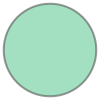

In [12]:
point0.buffer(1)

In [13]:
point0.buffer(1).area

3.13654849054594

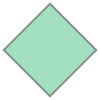

In [14]:
point0.buffer(1, resolution=1)

In [15]:
point0.buffer(1, resolution=1).area

2.0

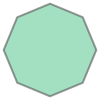

In [16]:
point0.buffer(1, resolution=2)

In [17]:
res_list = [10** x for x in range(8)]
for res in res_list:
    print(point0.buffer(1, resolution=res).area)

2.0
3.1286893008046204
3.1414634623641327
3.1415913616617597
3.141592640670475
3.141592653460551
3.1415926535884457
3.1415926535895258


### LineString

In [18]:
first_line_string = LineString([point0, point1])

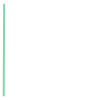

In [19]:
first_line_string

In [20]:
print(point0.x)
print(point0.y)
print('- '* 10)
print(point1.x)
print(point1.y)

121.52092997055541
25.088019988074905
- - - - - - - - - - 
121.52075001109426
25.049939996120486


In [21]:
# get info of point0
print(first_line_string.xy)
print(type(first_line_string))
print(first_line_string.area)
print(first_line_string.bounds) # minx, miny, maxx, maxy
print(first_line_string.geom_type)
print(first_line_string.is_valid)
print(first_line_string.length)
print(first_line_string.centroid)

(array('d', [121.52092997055541, 121.52075001109426]), array('d', [25.088019988074905, 25.049939996120486]))
<class 'shapely.geometry.linestring.LineString'>
0.0
(121.52075001109426, 25.049939996120486, 121.52092997055541, 25.088019988074905)
LineString
True
0.03808041718070139
POINT (121.52083999082485 25.068979992097695)


### Polygon

In [22]:
# get lat and lng of addr_2
addr_2 = dis_longterm.loc[2, 'addr']
addr_2_info = geocoder.arcgis(addr_2)
addr_2_lng = addr_2_info.json['lng']
addr_2_lat = addr_2_info.json['lat']
point2 = Point(addr_2_lng, addr_2_lat)

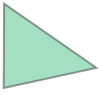

In [23]:
first_polygon = Polygon((point0, point1, point2))
first_polygon

## GeoSeries

In [24]:
# define a geoseries
s = gpd.GeoSeries(
    [
        Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
        Polygon([(10, 0), (10, 5), (0, 0)]),
        Polygon([(0, 0), (2, 2), (2, 0)]),
        LineString([(0, 0), (1, 1), (0, 1)]),
        Point(0, 1)
    ]
)

In [25]:
s.length

0     4.000000
1    26.180340
2     6.828427
3     2.414214
4     0.000000
dtype: float64

In [26]:
s.area

0     1.0
1    25.0
2     2.0
3     0.0
4     0.0
dtype: float64

In [27]:
s.bounds

,minx,miny,maxx,maxy
0,0.0,0.0,1.0,1.0
1,0.0,0.0,10.0,5.0
2,0.0,0.0,2.0,2.0
3,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0


In [28]:
s.boundary

0    LINESTRING (0.00000 0.00000, 0.00000 1.00000, ...
1    LINESTRING (10.00000 0.00000, 10.00000 5.00000...
2    LINESTRING (0.00000 0.00000, 2.00000 2.00000, ...
3        MULTIPOINT (0.00000 0.00000, 0.00000 1.00000)
4                             GEOMETRYCOLLECTION EMPTY
dtype: geometry

In [29]:
s.total_bounds

array([ 0.,  0., 10.,  5.])

In [30]:
s.geom_type

0       Polygon
1       Polygon
2       Polygon
3    LineString
4         Point
dtype: object

In [31]:
s.distance(Point(-1, -1))

0    1.414214
1    1.414214
2    1.414214
3    1.414214
4    2.236068
dtype: float64

## GeoDataFrame

In [32]:
d = {
    'col1': ['name1', 'name2'],
    'geometry': [Point(1, 2), Point(2, 1)]
}
gdf = gpd.GeoDataFrame(d, crs='EPSG:4326', geometry='geometry')
gdf

,col1,geometry
0,name1,POINT (1.00000 2.00000)
1,name2,POINT (2.00000 1.00000)


###  crs (Coordinate Reference System)
The coordinate reference system (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. This can be referred to using the authority code **"EPSG:4326"**.

In Taiwan, the commonly used Coordinate Reference System (CRS) is **"EPSG:3826.**" After converting from EPSG:4326 to EPSG:3826, the units for its x and y coordinates become **meter**.

In [ ]:
# get 臺北市區界圖 from data.taipei
URL = 'https://data.taipei/api/frontstage/tpeod/dataset/resource.download?rid=d8b7eb29-136f-49fc-b14b-3489d3656122'
FILE_NAME = 'tpe_district_border.zip'
!wget $URL -O $FILE_NAME
!unzip -d tpe_district_border -O BIG5 $FILE_NAME

In [33]:
district_border = gpd.read_file('tpe_district_border', encoding='utf-8')
district_border.head(2)

,AREA,PERF_ID,COUN_ID,CPID,CPTID,NPID,NPTID,PNAME,TNAME,PTNAME,TM2_MAX_X,TM2_MAX_Y,TM2_MIN_X,TM2_MIN_Y,MAX_X,MAX_Y,MIN_X,MIN_Y,geometry
0,5.738380e+07,63012.0,6301200,63012,6301200,63012.0,6301200.0,臺北市,北投區,臺北市北投區,307802.1700,2.789176e+06,296266.0530,2.776476e+06,121.57361,25.21014,121.45871,25.09588,"POLYGON ((302675.668 2785251.546, 302675.502 2..."
1,6.110781e+07,63011.0,6301100,63011,6301100,63011.0,6301100.0,臺北市,士林區,臺北市士林區,311328.6318,2.787546e+06,296551.1512,2.774091e+06,121.60853,25.19528,121.46145,25.07434,"POLYGON ((307802.170 2787372.760, 307831.907 2..."


In [34]:
district_border.crs = 'EPSG:3826'
district_border.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan, Republic of China - between 120°E and 122°E, onshore and offshore - Taiwan Island.
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [35]:
district_border = district_border[['PTNAME', 'geometry']]
district_border.head(3)

,PTNAME,geometry
0,臺北市北投區,"POLYGON ((302675.668 2785251.546, 302675.502 2..."
1,臺北市士林區,"POLYGON ((307802.170 2787372.760, 307831.907 2..."
2,臺北市內湖區,"POLYGON ((310064.640 2778552.346, 310063.746 2..."


In [36]:
district_border.crs = 'EPSG:3826'
district_border.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan, Republic of China - between 120°E and 122°E, onshore and offshore - Taiwan Island.
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [37]:
district_border = district_border.to_crs('EPSG:4326')
district_border.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [38]:
district_border.head(3)

,PTNAME,geometry
0,臺北市北投區,"POLYGON ((121.52259 25.17489, 121.52259 25.174..."
1,臺北市士林區,"POLYGON ((121.57354 25.19386, 121.57383 25.194..."
2,臺北市內湖區,"POLYGON ((121.59560 25.11414, 121.59559 25.114..."


In [39]:
dis_longterm

,_id,_importdate,type,name,addr,tel,attr,town
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,待查,士林區
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,待查,中山區
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,待查,松山區
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,待查,信義區


In [40]:
# set column 'geometry'
dis_longterm['geometry'] = dis_longterm['addr'].apply(
    lambda x: Point(
        geocoder.arcgis(x).json['lng'],
        geocoder.arcgis(x).json['lat']
    )
)

# from pd to gpd
dis_longterm = gpd.GeoDataFrame(
    dis_longterm,
    crs='EPSG:4326'
)

# change crs
dis_longterm = dis_longterm.to_crs('EPSG:3826')

In [41]:
# get distance (unit = m)
dis_longterm.loc[0, 'geometry'].distance(
    dis_longterm.loc[1, 'geometry']
)

4218.0307886983055

In [42]:
dis_longterm

,_id,_importdate,type,name,addr,tel,attr,town,geometry
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,待查,士林區,POINT (302545.613 2775628.160)
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,待查,中山區,POINT (302543.704 2771410.130)
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,待查,松山區,POINT (306760.234 2772437.213)
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,待查,信義區,POINT (307208.130 2769567.975)


## Manipulations

### Intersect

In [43]:
# change crs
district_border = district_border.to_crs('EPSG:3826')

# get buffer
dis_longterm['buffer'] = dis_longterm['geometry'].buffer(1000)
buffer0 = dis_longterm.loc[0, 'buffer']

In [44]:
# get the districts that intersect with buffer0
idx = buffer0.intersects(district_border['geometry'])
print(idx)
print('- '* 20)
print(district_border[idx].PTNAME.tolist())

0     False
1      True
2     False
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
Name: geometry, dtype: bool
- - - - - - - - - - - - - - - - - - - - 
['臺北市士林區', '臺北市中山區', '臺北市大同區']


### Overlay

In [45]:
polys1 = gpd.GeoSeries(
    [
        Polygon([(0,0), (2,0), (2,2), (0,2)]),
        Polygon([(2,2), (4,2), (4,4), (2,4)])
    ]
)


polys2 = gpd.GeoSeries(
    [
        Polygon([(1,1), (3,1), (3,3), (1,3)]),
        Polygon([(3,3), (5,3), (5,5), (3,5)])
    ]
)


df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

<Axes: >

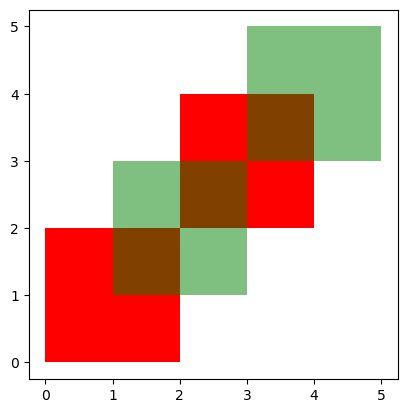

In [46]:
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5)

In [47]:
# how='union'
res_union = df1.overlay(df2, how='union')
res_union

,df1,df2,geometry
0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,2.0,NaN,"MULTIPOLYGON (((3.00000 3.00000, 4.00000 3.000..."
5,NaN,1.0,"MULTIPOLYGON (((2.00000 2.00000, 3.00000 2.000..."
6,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


In [48]:
res_union.explode().reset_index()

/var/folders/f_/jlrntldn06g41fwxs9z9fbjh0000gn/T/ipykernel_23829/1109923995.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  res_union.explode().reset_index()


,level_0,level_1,df1,df2,geometry
0,0,0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,1,0,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2,0,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,3,0,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,4,0,2.0,NaN,"POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4...."
5,4,1,2.0,NaN,"POLYGON ((3.00000 3.00000, 2.00000 3.00000, 2...."
6,5,0,NaN,1.0,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3...."
7,5,1,NaN,1.0,"POLYGON ((2.00000 2.00000, 1.00000 2.00000, 1...."
8,6,0,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


<Axes: >

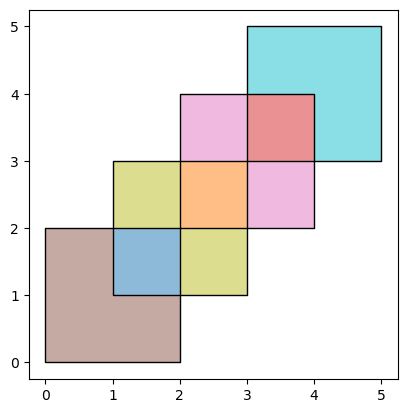

In [49]:
ax = res_union.plot(alpha=0.5, cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

In [50]:
# how='intersection'
res_intersection = df1.overlay(df2, how='intersection')
res_intersection

,df1,df2,geometry
0,1,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2,1,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2,2,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."


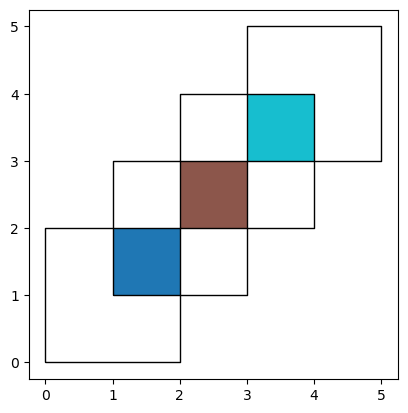

In [51]:
ax = res_intersection.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');


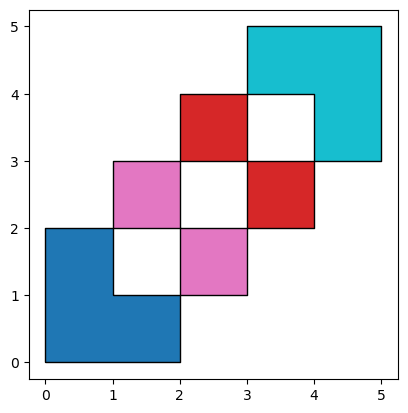

In [52]:
'''
how='symmetric_difference'
the opposite of 'intersection'
'''
res_symdiff = df1.overlay(df2, how='symmetric_difference')
ax = res_symdiff.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

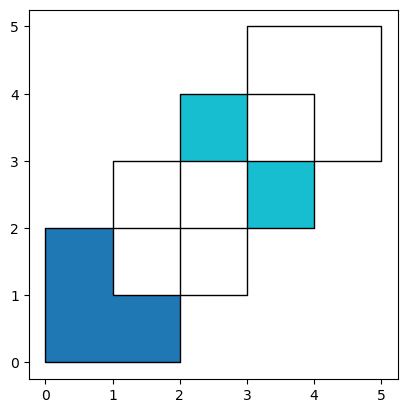

In [53]:
'''
how='difference'
obtain the geometries that are part of df1 but are not contained in df2
'''
res_difference = df1.overlay(df2, how='difference')
ax = res_difference.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

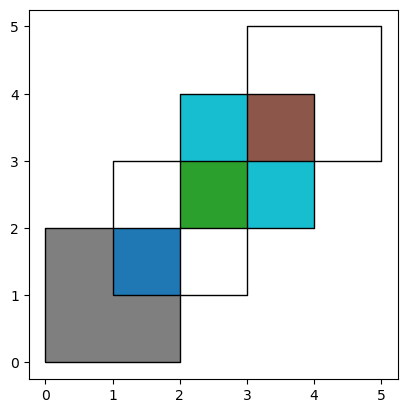

In [54]:
'''
how='identity'
the result consists of the surface of df1,
but with the geometries obtained from overlaying df1 with df2
'''
res_identity = df1.overlay(df2, how='identity')
ax = res_identity.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');


### E.g. the overlap area between long-term care facilities with buffer and administrative districts

In [55]:
dis_longterm_buffer = dis_longterm[['name', 'buffer']]
dis_longterm_buffer = dis_longterm_buffer.set_geometry('buffer')

overlay_df = gpd.overlay(
    dis_longterm_buffer,
    district_border,
    how='union'
).explode().reset_index()

overlay_df

/var/folders/f_/jlrntldn06g41fwxs9z9fbjh0000gn/T/ipykernel_23829/1573161990.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ).explode().reset_index()


,level_0,level_1,name,PTNAME,geometry
0,0,0,士林失能身障日照中心,臺北市士林區,"POLYGON ((303540.798 2775530.143, 303526.398 2..."
1,1,0,士林失能身障日照中心,臺北市中山區,"POLYGON ((303469.493 2775245.477, 303427.534 2..."
2,2,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區,"POLYGON ((303538.889 2771312.112, 303524.490 2..."
3,3,0,士林失能身障日照中心,臺北市大同區,"POLYGON ((302074.216 2774746.239, 302059.273 2..."
4,4,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市大同區,"POLYGON ((301548.520 2771312.112, 301543.704 2..."
5,5,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市中正區,"POLYGON ((303425.626 2770938.733, 303375.174 2..."
6,6,0,臺北市民生身障社區式長照機構（日間照顧）,臺北市內湖區,"POLYGON ((307755.419 2772339.196, 307741.020 2..."
7,7,0,臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區,"POLYGON ((307642.156 2771965.816, 307591.704 2..."
8,8,0,臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區,"POLYGON ((308203.315 2769469.958, 308188.915 2..."
9,9,0,臺北市信義身障社區式長照機構（日間照顧）,臺北市大安區,"POLYGON ((306227.345 2769372.884, 306212.945 2..."


In [56]:
overlay_df['geometry'].area

0     3.044400e+06
1     9.154184e+04
2     1.098532e+06
3     6.069314e+02
4     8.642152e+05
5     1.173800e+06
6     1.378886e+05
7     2.998660e+06
8     3.117763e+06
9     1.878498e+04
10    3.580674e-10
11    2.728973e-09
12    9.589520e-06
13    2.968405e-01
14    9.100278e-03
15    1.314581e-01
16    3.656399e-01
17    1.290126e-03
18    5.995269e-04
19    1.747772e-04
20    1.852653e-06
21    3.297013e-05
22    9.954847e-03
23    6.510426e-03
24    4.390402e-04
25    4.906428e-03
26    5.024801e-03
27    1.686159e-04
28    5.738380e+07
29    5.789722e+07
30    1.661904e+05
31    3.181394e+07
32    1.268632e+07
33    3.906514e+06
34    5.682794e+06
35    2.195662e+07
36    6.368075e+06
37    8.121732e+06
38    7.449655e+06
39    1.132080e+07
40    3.125012e+07
dtype: float64

# Kepler in Python

In [57]:
from keplergl import KeplerGl

map_ = KeplerGl(height=700)
map_.add_data(
    data=overlay_df[overlay_df.area<1],
    name='overlay_df'
)
map_.add_data(
    data=district_border,
    name='dist_border'
)
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/homebrew/anaconda3/lib/python3.11/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'overlay_df': {'index': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27…

# 儀表板資料格式轉換

For the input format of the dashboard, you can refer to this [link](https://tuic.gov.taipei/documentation/front-end/chart-data).

## save as GeoJson

In [58]:
dis_longterm['fax'] = ''
dis_longterm['is_accessi'] = ''
dis_longterm['code'] = ['C01010001', 'C01010002', 'C01010003', 'C01010004']
dis_longterm.head()

,_id,_importdate,type,name,addr,tel,attr,town,geometry,buffer,fax,is_accessi,code
0,1,"{'date': '2023-06-12 11:35:30.960719', 'timezo...",身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272,待查,士林區,POINT (302545.613 2775628.160),"POLYGON ((303545.613 2775628.160, 303540.798 2...",,,C01010001
1,2,"{'date': '2023-06-12 11:35:30.969898', 'timezo...",身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032,待查,中山區,POINT (302543.704 2771410.130),"POLYGON ((303543.704 2771410.130, 303538.889 2...",,,C01010002
2,3,"{'date': '2023-06-12 11:35:30.971480', 'timezo...",身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605,待查,松山區,POINT (306760.234 2772437.213),"POLYGON ((307760.234 2772437.213, 307755.419 2...",,,C01010003
3,4,"{'date': '2023-06-12 11:35:30.972983', 'timezo...",身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933,待查,信義區,POINT (307208.130 2769567.975),"POLYGON ((308208.130 2769567.975, 308203.315 2...",,,C01010004


In [135]:
dis_institution.head()

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lng,lat,is_accessi,geometry
0,1,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
1,2,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,POINT (300362.000 2765326.000)
2,3,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是,POINT (303689.900 2778225.000)
3,4,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.00,121.549477,25.110765,否,POINT (305415.200 2778159.000)
4,5,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.00,121.541206,25.135172,否,POINT (304569.600 2780859.000)


In [136]:
# set column 'geometry'
dis_longterm['geometry'] = dis_longterm['addr'].apply(
    lambda x: Point(
        geocoder.arcgis(x).json['lng'],
        geocoder.arcgis(x).json['lat']
    )
)

# from pd to gpd
dis_longterm = gpd.GeoDataFrame(
    dis_longterm,
    crs='EPSG:4326'
)
dis_longterm['lng'] = dis_longterm['geometry'].x
dis_longterm['lat'] = dis_longterm['geometry'].y

# change crs
dis_longterm = dis_longterm.to_crs('EPSG:3826')
dis_longterm['x'] = dis_longterm['geometry'].x
dis_longterm['y'] = dis_longterm['geometry'].y
dis_longterm['geometry'] = dis_longterm['geometry'].buffer(1000)

# change crs
dis_longterm = dis_longterm.to_crs('EPSG:4326')

In [137]:
dis_institution['geometry'] = dis_institution['geometry'].buffer(1000)
dis_institution = dis_institution.to_crs('EPSG:4326')

In [138]:
dis_friendly_institution = pd.concat([dis_institution, dis_longterm])
dis_friendly_institution.head()

,OBJECTID,code,name,attr,type,town,address,tel,fax,x,y,lng,lat,is_accessi,geometry,_id,_importdate,addr
0,1.0,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,"POLYGON ((121.50881 24.99505, 121.50876 24.994...",NaN,NaN,NaN
1,2.0,B01010001,崇愛發展中心,公設民營,住宿機構,中和區,新北市中和區正行里7鄰圓通路143-1號,(02)2246-0821,(02)2247-0360,300361.96875,2765326.25,121.498909,24.995089,是,"POLYGON ((121.50881 24.99505, 121.50876 24.994...",NaN,NaN,NaN
2,3.0,B01010002,臺北市三玉啟能中心,公設民營,住宿機構,士林區,臺北市士林區忠誠路二段53巷7號3、4、7樓,(02)8866-5931,(02)8866-5930,303689.90625,2778225.00,121.532379,25.111423,是,"POLYGON ((121.54229 25.11139, 121.54224 25.110...",NaN,NaN,NaN
3,4.0,B01010003,臺北市永福之家,公設民營,住宿機構,士林區,臺北市士林區永福里5鄰莊頂路2號,(02)2861-1381#2011,(02)2862-1793,305415.18750,2778159.00,121.549477,25.110765,否,"POLYGON ((121.55940 25.11073, 121.55934 25.109...",NaN,NaN,NaN
4,5.0,B01010004,臺北市立陽明教養院(華岡院區),公立,住宿機構,士林區,臺北市士林區陽明里8鄰凱旋路61巷4弄9號,(02)2861-1380,(02)2861-8004,304569.59375,2780859.00,121.541206,25.135172,否,"POLYGON ((121.55112 25.13513, 121.55107 25.134...",NaN,NaN,NaN


In [139]:
dis_friendly_institution.shape

(179, 18)

In [142]:
dis_friendly_institution.to_file(
    'disable_friendly_institution.geojson',
    driver='GeoJSON'
)

## save as json

### Two-Dimensional Data

In [ ]:
TP_daycare_town = gpd.read_file('Datasets/Processed/TP_daycare_town.geojson')
TP_daycare_town['NUMPOINTS'] = TP_daycare_town['NUMPOINTS'].astype(int)

specified_order = [
    '北投區', '士林區', '內湖區', '南港區',
    '松山區', '信義區', '中山區', '大同區',
    '中正區', '萬華區', '大安區', '文山區'
]
mapping = {y: x for x, y in enumerate(specified_order)}

TP_daycare_town['sort_idx'] = TP_daycare_town['TNAME'].apply(lambda x: mapping[x])
TP_daycare_town.sort_values(by=['sort_idx'], inplace=True)

In [ ]:
TP_daycare_town.head(5)

,AREA,COUN_ID,PNAME,TNAME,PTNAME,MAX_X,MAX_Y,MIN_X,MIN_Y,NUMPOINTS,geometry,sort_idx
0,5.738380e+07,6301200,臺北市,北投區,臺北市北投區,121.57361,25.21014,121.45871,25.09588,3,"MULTIPOLYGON (((121.52259 25.17489, 121.52259 ...",0
1,6.110781e+07,6301100,臺北市,士林區,臺北市士林區,121.60853,25.19528,121.46145,25.07434,3,"MULTIPOLYGON (((121.57354 25.19386, 121.57383 ...",1
2,3.195183e+07,6301000,臺北市,內湖區,臺北市內湖區,121.62848,25.11483,121.55181,25.05186,2,"MULTIPOLYGON (((121.59560 25.11414, 121.59559 ...",2
6,2.195662e+07,6300900,臺北市,南港區,臺北市南港區,121.66605,25.06432,121.57765,25.01224,1,"MULTIPOLYGON (((121.57979 25.05294, 121.57986 ...",3
5,8.680668e+06,6300100,臺北市,松山區,臺北市松山區,121.58019,25.07587,121.53824,25.04435,2,"MULTIPOLYGON (((121.57610 25.04940, 121.57594 ...",4


In [ ]:
results = {
    'data': [
        {
            'name':'',
            'data': [
                {
                    'x': x,
                    'y': y
                }
                for x, y in zip(
                    TP_daycare_town['TNAME'],
                    TP_daycare_town['NUMPOINTS']
                )
            ]
        }
    ]
}

In [ ]:
results

{'data': [{'name': '',
   'data': [{'x': '北投區', 'y': 3},
    {'x': '士林區', 'y': 3},
    {'x': '內湖區', 'y': 2},
    {'x': '南港區', 'y': 1},
    {'x': '松山區', 'y': 2},
    {'x': '信義區', 'y': 4},
    {'x': '中山區', 'y': 4},
    {'x': '大同區', 'y': 1},
    {'x': '中正區', 'y': 3},
    {'x': '萬華區', 'y': 2},
    {'x': '大安區', 'y': 0},
    {'x': '文山區', 'y': 2}]}]}

In [ ]:
with open('Processed_by_ETL/chart_data/TP_daycare_town.json', "w") as json_file:
    json.dump(results, json_file, ensure_ascii=False)

### Three-Dimensional Data

In [ ]:
disability_demand_trend = pd.read_csv(
    'Datasets/Processed/無障礙需求歷年趨勢.csv',
    thousands=','
)

disability_demand_trend['年份'] = disability_demand_trend['年份'].str.replace('年', '-01-01')
disability_demand_trend['年份'] = Preload().convert_str_to_time_format(
    column=disability_demand_trend['年份'],
    from_format='y-m-d'
)
disability_demand_trend['年份'] = disability_demand_trend['年份'].map(
    lambda x: x.isoformat()
).str.replace('+08:00', 'Z')

disability_demand_trend.head(3)

*H* not found, only *ymd*


,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995-01-01T00:00:00Z,37007518,123629720,67958515
1,1996-01-01T00:00:00Z,91367929,265961218,59513472
2,1997-01-01T00:00:00Z,68788296,168770548,63790107


In [ ]:
cols = list(disability_demand_trend)
cols.remove('年份')

results = {
    'data': [
        {
            'name': col,
            'data': [
                {
                    'x': x,
                    'y': y
                }
                for x, y in zip(
                    disability_demand_trend['年份'],
                    disability_demand_trend[col]
                )
            ]
        }
        for col in cols
    ]
}

with open('Processed_by_ETL/chart_data/disability_demand_trend.json', "w") as json_file:
    json.dump(results, json_file, ensure_ascii=False)


In [ ]:
results

{'data': [{'name': '日間及住宿式照顧補助金額(元)',
   'data': [{'x': '1995-01-01T00:00:00Z', 'y': 37007518},
    {'x': '1996-01-01T00:00:00Z', 'y': 91367929},
    {'x': '1997-01-01T00:00:00Z', 'y': 68788296},
    {'x': '1998-01-01T00:00:00Z', 'y': 174731400},
    {'x': '1999-01-01T00:00:00Z', 'y': 158774563},
    {'x': '2000-01-01T00:00:00Z', 'y': 405985325},
    {'x': '2001-01-01T00:00:00Z', 'y': 613709172},
    {'x': '2002-01-01T00:00:00Z', 'y': 683857039},
    {'x': '2003-01-01T00:00:00Z', 'y': 732591017},
    {'x': '2004-01-01T00:00:00Z', 'y': 596227191},
    {'x': '2005-01-01T00:00:00Z', 'y': 567746993},
    {'x': '2006-01-01T00:00:00Z', 'y': 575093412},
    {'x': '2007-01-01T00:00:00Z', 'y': 530348362},
    {'x': '2008-01-01T00:00:00Z', 'y': 629298222},
    {'x': '2009-01-01T00:00:00Z', 'y': 677897043},
    {'x': '2010-01-01T00:00:00Z', 'y': 745310746},
    {'x': '2011-01-01T00:00:00Z', 'y': 885733255},
    {'x': '2012-01-01T00:00:00Z', 'y': 965652889},
    {'x': '2013-01-01T00:00:00Z', 'y': 

# 實作 - 整理儀表板可用的資料